<a href="https://colab.research.google.com/github/aune150/ConnectToOlt/blob/main/Computational_Essay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Essay FYS1120 - 2024

By Charlotte Beate Seibt og Erlend Aune


## Topic - Northerns Lights (aurora borealis)
What kind of methods can one use to simulate the aurora borealis using a computer?

We ar egoing to take two different atricles as insperation to see two different aproches to simulating the aurora borealis.


## First method:
The first method we will present is based on this report: http://pedrinho.cs.uwaterloo.ca/~gvgbaran/cgpub/aurora1.pdf

**Steps:**
1. Implement earths magnetic field
2. Implement the solar wind as electron sheets
3. Calculating the trajectories of the electrons along the geomagnetic field lines
4. Computation of light emissions along particle paths
5. Rendering the aurora

For this computation essay, steps 1 - 3 were implemented, while steps 4 -5 ultimately were decided on being too complex and computationally intensive. However, an overview of the final steps will be presented at the end as well as a discussion of this method.  

# 1. Implement Earths magnetic field


For this report, earths magnetic field was implement as a dipole model based on the following website:  https://scipython.com/blog/visualizing-the-earths-magnetic-field/

**Model**

This lecture presents a first-order approximationf of Earth's magnetic field using a dipole model. We define the magnetic poles as positions where the horizontal component of the magnetic field is zero, and the magnetic equator as the curve where the vertical component is zero.

**Derivation of the equations**

We start with the equation for a magnetic dipole moment $\mathbf m$ at a point $\mathbf r$:
$$
\mathbf B(\mathbf r) = \frac{\mu_0}{4\pi r^3} \left[ 3 \hat{r} (\hat{r} \cdot \mathbf{m}) - \mathbf{m} \right]
$$

Next up, we define $B_0$ to be the magnetic field at the Earth's magnetic equator. So $r = R_E$ and $\mathbf {\hat r} \cdot \mathbf m = 0$. Inserting this into the above equation we get:
$$
\mathbf B_0 = -\frac{\mu_0 m}{4\pi R_E^3} \mathbf {\hat j}  = B_0\mathbf {\hat j}
$$

The general expresion for the magnetic field therefore becomes:
$$
\mathbf{B}(r) = - B_0 \left( \frac{R_E}{r} \right)^3 \left[ 3 \cos \theta \hat{r} - \hat{j} \right]
$$

The expression $3 \cos \theta \hat{r} - \hat{j}$ comes from the vector expansion of the dipole field in spherical coordinates.

The website continues with calculating the radial component by taking the dot product of $\mathbf B(r)$ with the radial unit vector $\hat r$:
$$
B_r = \mathbf{B} \cdot \hat{r} = -B_0 \left( \frac{R_E}{r} \right)^3 \left[ 3 \cos \theta - \cos \theta \right] = -2 B_0 \left( \frac{R_E}{r} \right)^3 \cos \theta
$$

The angular component is computed in much the same way:
$$
B_\theta = \mathbf{B} \cdot \hat{\theta} = -B_0 \left( \frac{R_E}{r} \right)^3 \left[ -\hat{j} \cdot \hat{\theta} \right] = -B_0 \left( \frac{R_E}{r} \right)^3 \sin \theta
$$

We will visualize the magnetic field with streamplots, where we first construct a meshgrid of (x,y) coordinates, which we will convert to polar coordinates, give to our function for calculating the magnetic field and lastly convert back into cartesian coordinates.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [ ]:
B_0 = 3.12e-5 # Magnetic field strength at equator [T]
R_E = 6.37e6 # Earth's radius [m]
tilt = np.radians(9.6) # Geographical tilt from magnetic poles

In [ ]:
# Magnetic Field components in spherical coordinates
def Bfield(R, theta):
    B_r = -2* B_0 * (R_E / R)**3 * np.cos(theta + tilt)
    B_theta = - B_0 * (R_E / R)**3 * np.sin(theta + tilt)
    return B_r, B_theta

# Calculating the polar coordinates to cartesian coordinates
def polar_to_cartesian(B_r, B_theta, theta):
  Bx = B_r * np.cos(theta) - B_theta * np.sin(theta)
  By = B_r * np.sin(theta) + B_theta * np.cos(theta)
  return Bx, By

In [ ]:
# Grid setup
n_grid = 100 # Resolution of grid
ax_lim = 40e6 # Axis Limit [m]
x = np.linspace(-ax_lim, ax_lim, n_grid)
y = np.linspace(-ax_lim, ax_lim, n_grid)
X, Y = np.meshgrid(x, y)

# Convert grid points to polar coordinates
r = np.sqrt(X**2 + Y**2)
theta = np.arctan2(Y, X)

# Compute magnetic field in polar coordinates, then convert to cartesian
B_r, B_theta = Bfield(r, theta)
Bx, By = polar_to_cartesian(B_r, B_theta, theta)

Text(0.5, 1.0, "Earth's Magnetic Dipole Field")

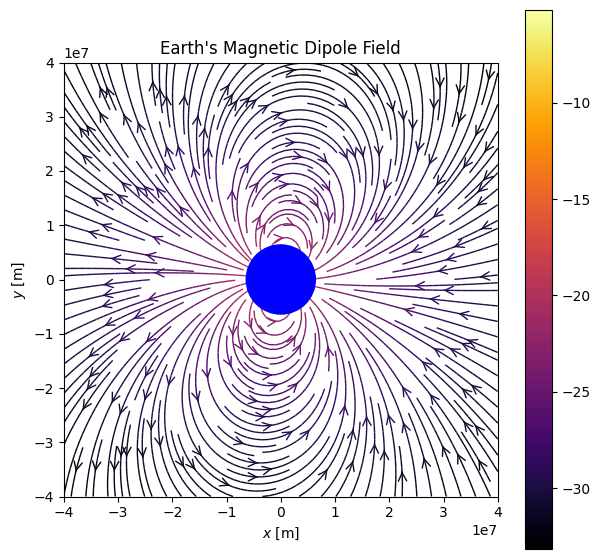

In [ ]:
# Visualization
plt.figure(figsize=(7,7))
field_magnitude = 2 * np.log(np.hypot(Bx, By))
plt.streamplot(x, y, Bx, By, color=field_magnitude, linewidth=1, cmap=plt.cm.inferno, density=2, arrowstyle="->", arrowsize=1.5)

# Adding Earth
earth = Circle((0,0), R_E, color="b", zorder=100)
plt.gca().add_patch(earth)

plt.colorbar()
plt.xlabel(r"$x$ [m]")
plt.ylabel(r"$y$ [m]")
plt.xlim(-ax_lim, ax_lim)
plt.ylim(-ax_lim, ax_lim)
plt.gca().set_aspect("equal")
plt.title("Earth's Magnetic Dipole Field")

# 2. Implementing the solar wind as electron sheets
To model the solar wind's interaction with Earth's magnetosphere, we'll use a sheet-based approach rather than looking at the trajectory of individual electrons (more efficient).

Our model represents electron beams as sheets, where each sheet is composed of multiple layers. These layers are defined by sine waves, creating an undulating structure to mimic what we see in nature.

To construct these sheets, we'll use a parametric approach, where each point P on the sheet is defined by two paramters:
1. $ s \in [0,1]$: represents the longtitudinal position along the sheet
2. $\Phi_r \in [\phi_r^i, \phi_r^f]$: represents the angular position in the sine wave.

We will also implement a phase shift between layers such that each layer's sine wave begins at a different initial angle $\Phi_r^i$.

1. First we define the **parameters for the electron sheet** by the following parameters:
- $w$: Thickness (1-10 km) (i.e. how spread out the electron stream is)
- $\phi$: Phase shift of electron sheet boundaries (up to 0.35 $\pi$ radians) -> sheets start at different initial angles -> undulating patterns
- $\lambda$: Wavelength (varies). Determines the periodicity of the sine waves that define the electron sheet boundaries.
- $n$: Number of discrete electron beams we will simulate
- $b$: : Number of internal layers within the sheet (i.e. the stratification within the electron stream)
- $P_i, P_f$:  Coordinates of the sheet extremities (define length and direction). We'll model the interactions of the solar wind with earths magnetosphere at 100 km (it starts at 60 km)
- $ds$: Longitudinal distance between neighbouring beams
- $\phi_r$: Angular coordinate (defiens position within the sine wave)

2. Next up we compute relevant **vectors**:
- $ u_a = P_f - P_i $: Vector from the starting to the endingp point of the sheet, representing the sheet's primary direction
- $ D = \vert u_a \vert $: Magnitude of $ u_a$
- $ u_b = B \times u_a $ Cross Product of the geomagnetic field  $B$ and $u_a$
3. Now we calculate the starting points with the following **parametric equation** that determines the position of each electron beam starting point along the sine wave:
$$ P(s, \phi_r) = u_a (s) + w \sin (\phi_r)\frac {u_b}{\vert u_b \vert} $$
- Where the angular increment $ \phi_r $ is based on the distance and the number of beams and wavelength:
$$ \phi_r^{\text{new}} = \phi_r^{\text{old}} + \Delta \phi_r =  \phi_r^{\text{old}} +
\frac D n \cdot \frac {2 \pi}{\lambda} $$
- And the parametric interval $s$ is:
$$ s^{\text{new}} = s^{\text{old}} + (ds \pm \delta s) $$
where $\delta s$ is a uniformly distributed random number in the interval [0,1].
  - If $\delta s > 0.5 $ : add to $ds$
  - If $\delta s < 0.5 $ : subtract from to $ds$
  --> Random displacement to represent the stochastic nature

In [ ]:
# Electron sheet parameters
b = 5 # Internal layers
n = 100 # Points per layer
w = 10e3 # Thickness [m]
lambda_ = 30e3 # Wavelength for the variation [m]
phi = 0.35 * np.pi # Max phase shift between layers [rad]
P_i = np.array([0, 0, 100e3]) # Starting point [m]
P_f = np.array([100e3, 0, 100e3]) # Ending point [m]
ds = 1e3 # Perturbation in longitudinal distance (to introduce randomness) [m]

# Magnetic field at 100km (assuming it's along the z-axis)
B_100 = np.array([0, 0, 5e-5]) # [T]

# Compute vectors
u_a = P_f - P_i
D = np.linalg.norm(u_a)
u_b = np.cross(B_100, u_a)

starting_points = np.zeros((b*n, 3))
for layer in range(b):
  layer_phase = layer * phi / (b-1) # Distribute phase shift across layers
  for si, s in enumerate(np.linspace(0, 1, n)):
    s += np.random.uniform(-0.5, 0.5) * ds / D # Random displacement
    phi_r = 2 * np.pi * s * D / (lambda_ * n) + layer_phase
    P = u_a * s + w * np.sin(phi_r) * (u_b / np.linalg.norm(u_b))
    starting_points[layer*n + si] = P + P_i    # Adding P_i to get world coordinates

## Step 3: Calculating the trajectories

Now that we have the modeled the electron sheets as sine waves we can simulate their trajectory when they interact with earths magentosphere.  

First, we define the lorentz force, which  governs the electron's spiral motion along the magnetic field lines and the force on one charge particle is calculated the following way:
$$ \mathbf F_L = q \cdot \mathbf v \times \mathbf B $$

The function for updating the trajectory calculates magnetic field based on the current distance $ R $ and polar angle $ \theta $, calculates the Lorentz force and acceleration using Newtons second law:
$$ \sum \mathbf F = \mathbf F_L = m \mathbf a \implies \mathbf a = \frac{ \mathbf F_L}{m} $$
And the position and speed are updated using the Euler-Cromer method:

$$ v_{\text{new}} = v_{\text{old}} + \frac F m \Delta t $$

$$ r_{\text{new}} = r_{\text{old}} + v_{\text{new}} \Delta t $$

Our main code here loops over each electron beam, calculating the trajectory at 1000 time steps.

In [ ]:
q = -1.6e-31 # Electron charge [C]
m = 9.11e-31 # Elektron masse [kg]
dt = 1e-6 # Time step [s]

def lorentz_force(q, v, B):
  return q * np.cross(v, B)

def update_trajectory(position, velocity, dt):
  R = np.linalg.norm(position)
  theta = np.arccos(position[2] / R) # theta based on z-coordinatees
  B = Bfield(R, theta)
  F = lorentz_force(q, velocity, B)
  acceleration = F / m
  velocity += acceleration * dt
  position += velocity * dt
  return position, velocity

N = 1000 # Antall tidssteg
trajectories = []
for i in range(b*n):
  pos = starting_points[i]
  vel = np.random.uniform(-1e7, 1e7, 3) # Random initial velocities
  trajectory = np.zeros((N, 3))
  trajectory[0] = pos
  for j in range(N - 1): # Simulate for 1000 time steps
    pos, vel = update_trajectory(pos, vel, dt)
    trajectory[j + 1] = pos
  trajectories.append(trajectory)

trajectories = np.array(trajectories)

## Steps 4 - 5: Computing the light emissions and rendering the aurora
4. Computation of light emissions along particle paths
- Calculate the energy of electrons at different altitudes
- Determine collision probabilities with the different atmospheric particles
- Calculate photon emissions based on collision frequency and excited states (wavelength)
5. Rendering the aurora
- Map light emissions to a 3D volume
- Apply view-dependent effects (perspectives, atmospheric scattering)
- Implement temporal variations and "blurring" techniques

## Discussion of this method
**Advantages**:
- Physically accurate simulations
- Ability to produce a wide variety of auroral forms and behaviours

**Disadvantages**:
- Computationally intensive
- Difficult to tune parameters to achieve desired visual results.

## Method 2

Metode 2 er basert på https://github.com/millskyle/AuroraSim/tree/master.



1.   Simulere elektroner i atmosfæren
2.   Beregne ladningstettheten fra alle elektronene
3.   Regne ut potensialet med Poisson's ligning → elektrisk felt
5.   Integrere opp akselrasjonen med Euler Cromer
6.   Modelere kollisjoner med partikkler som sender ut fotoner
7. Samle opp alle fotonene til et bilde



Poisson's equation:
$$ \nabla^2 V = - \frac{\rho}{ϵ_0} $$
Så kan det elektriske feltet regnes ut ved:

$$ \mathbf E = -∇V $$

Fra læreboka Ligning (6.1) kan Poisson's ligning skrives om som:
$$ V(\mathbf r) = \frac{1}{4πϵ_0} \int_v \frac{\rho (\mathbf r')}{|r - r'|}  \, dv' $$

Videre sier artikkelen at dette kan gjøres om til:
$$ V(\mathbf r) = -\frac{1}{8π^2ϵ_0} \int_v \frac{\mathcal F_\rho(\mathbf k)}{\mathbf k^2} e^{i \mathbf K \cdot \mathbf r}  \, d\mathbf k $$

Her er $\mathcal F_\rho(\mathbf k)$ Fourier transformasjonen av ladningstettheten. Videre blir det elektriske feltet:
$$ \mathbf E (\mathbf r) = -\nabla V(\mathbf r) = \frac{i}{8π^2ϵ_0} \int_v \frac{\mathbf k \mathcal F_\rho(\mathbf k)}{\mathbf k^2} e^{i \mathbf K \cdot \mathbf r}  \, d\mathbf k $$

Dette kan regnes ut ved numpy og scipy sine fourier transformasjoner. Da dette ikke er pensum i det hele tatt ble dette steget bare rent ignorert. I prinsippet kunne man ha regnet ut det elektriske feltet ved numerisk integrasjon ved den første ligningen, men dette vill tatt alt for lang tid i Python ettersom det er en veldig stor numerisk jobb som ikke egner seg i Python.

$B$ feltet er satt til $B = 1\hat y$ for enkelhetskyld. For hvert 5. tidssteg blir det elektriste feltet regnet ut ved: $\rho → V → \mathbf E$. For hvert tidssteg blir kreftene som virker på elektronene beregnet med Lorentz kraftlov:
$$ \mathbf F = q (\mathbf E + \mathbf v \times \mathbf B) $$
Deretter brukes Newtons andre lov til å regne ut akselrasjonen:
$$ \sum \mathbf F = m \mathbf a \implies \mathbf a = \frac{\mathbf F}{m} $$
Valgt integrasjonsmåte er Euler Cromer slik at:
$$ \mathbf v_{n+1} = \mathbf v_n + \mathbf a \cdot \Delta t $$
$$ \mathbf x_{n+1} = \mathbf x_n + \mathbf v_{n+1} \cdot \Delta t $$

### Antagelser:
Som i alle simuleringer av fysiske systemer må det gjøres antagelser som reduser kompleksiteten. I denne simulering er det gjort følgende antagelser:
- Bevegelsene av partiklene fører ikke til induserte magnetfelt eller lignende. Dette fører til at det er nok å bruke formlene fra elektrostatikken.
- Partikklene kolliderer ikke med hverandre. Det er veldig store avstander og få partikkler som fører til at dette er en ganske god antagelse.
- Det er antatt at alle partikklene er elektroner. Mestepareten av de ladde partikklene som fører til nordlys er elektroner, men det vil også være andre partikkler.
- Sannsynligheten for at et elektron kolliderer er gitt at en funksjon $∝ e^{-kz}$. Der $z$ er høyden over jorda.

### Feilkilder

I denne simuleringen er det veldig mye færre partikkler enn det eksempelet som det ble tatt utgangspunkt i. Dette er fordi Python ikke takler like mye som en bra skrevet C++ kode. Derfor har det vært nødvendig å kutte der det er mulig i koden for at den skal være kjørbar. Konstanter og skaleringer er rent kopiert fra artikkelen, da dette ville vært en stor jobb å endre på alt av numerisk logikk pluss at det er for oss ukjnet hvordan Fourier transformasjonen påvirker verdien på det elektriske feltet.

### Fordeler og ulemper
**Fordeler**
- Det er relativt enkelt å modelere krefter på elektronnivå
- Enklere å få en grafisk fremmstilling

**Ulemper**
- Det krever veldig mye regnekraft og er egentlig ikke mulig i Python med de mengdene av partikkler som kreves for fine bilder
- Kompleks Fourier transformsjoner gjør det vanskelig å forstå
- Vanskelig å finne variabler slik at det blir fine bilder

In [ ]:
import scipy.fft as fft
import random
import time

# Egene moduler
from electron import Electron
from IO import PhotonDensity
from IO import EnergyDensity

ModuleNotFoundError: No module named 'electron'

In [ ]:
class MagneticField:
    def __init__(self, strength: float = 1.0):
        self.B = np.array([0, strength, 0])

    def __call__(self, position: np.ndarray) -> np.ndarray:
        return self.B

Ladningstettheten $\rho$ blir kalkulert ved å diskretisere rommet i flere bokser for å så telle antall elektroner i de boksene.

In [ ]:
class ChargeDensity:
    def __init__(self, sim):
        self.resolution_x = 32
        self.resolution_y = 32
        self.resolution_z = 32
        self.resolution = np.array([self.resolution_x, self.resolution_y, self.resolution_z])
        self.p = np.zeros((self.resolution_x, self.resolution_y, self.resolution_z))

    def reset(self):
        self.p.fill(0)

In [ ]:
class ElectricField:
    def __init__(self, sim, rho):
        self.Nx = rho.resolution_x
        self.Ny = rho.resolution_y
        self.Nz = rho.resolution_z
        self.Lx = sim.box_sizex
        self.Ly = sim.box_sizey
        self.Lz = sim.box_sizez
        self.sim = sim
        self.rho = rho
        self.E = np.zeros((self.Nx, self.Ny, self.Nz, 3))

    def compute(self):
        rho_out = open(f"rho/rho_{self.sim.t:04d}.dat", "w")
        charge_density = self.rho.p / (self.sim.N * (self.Lx * self.Ly * self.Lz) / (self.Nx * self.Ny * self.Nz))
        in_data = np.zeros((self.Nx, self.Ny, self.Nz), dtype=np.complex128)
        in_data.real = charge_density

        out_data = fft.fftn(in_data)

        kx = np.fft.fftfreq(self.Nx, 1 / self.Nx)
        ky = np.fft.fftfreq(self.Ny, 1 / self.Ny)
        kz = np.fft.fftfreq(self.Nz, 1 / self.Nz)

        kx_2 = kx ** 2
        ky_2 = ky ** 2
        kz_2 = kz ** 2

        phi_x = -out_data.real / (kx_2[:, None, None] + ky_2[None, :, None] + kz_2[None, None, :] + 1e-20) / self.sim.epsilon_naught
        phi_y = -out_data.imag / (kx_2[:, None, None] + ky_2[None, :, None] + kz_2[None, None, :] + 1e-20) / self.sim.epsilon_naught
        phi_z = -out_data.real / (kx_2[:, None, None] + ky_2[None, :, None] + kz_2[None, None, :] + 1e-20) / self.sim.epsilon_naught

        self.E[:, :, :, 0] = fft.ifftn(1j * kx[:, None, None] * phi_x).real
        self.E[:, :, :, 1] = fft.ifftn(1j * ky[None, :, None] * phi_y).real
        self.E[:, :, :, 2] = fft.ifftn(1j * kz[None, None, :] * phi_z).real


        for k in range(self.Nz):
            for j in range(self.Ny):
                for i in range(self.Nx):
                    rho_out.write(f"{i} {j} {self.rho.p[i, j, k]}\n")
        rho_out.close()

    def __call__(self, position: np.ndarray) -> np.ndarray:
        i, j, k = position
        if 0 <= i < self.Nx and 0 <= j < self.Ny and 0 <= k < self.Nz:
            return self.E[i, j, k]
        else:
            return np.array([0, 0, 0])

Siste som er nødvendig er å definere en rekke parametre for simuleringen:

In [ ]:
class Simulation:
    k = 10  # number of particles will be N = 2^k
    tmax = 100
    t = 0
    dt = 0.01  # timestep

    # box size, in 'kilometers'
    box_sizex = 20.0
    box_sizey = 20.0
    box_sizez = 20.0
    box_size = np.array([box_sizex, box_sizey, box_sizez])

    E_field_recalc = 5  # how many timesteps between E_field recalculations

    # Mean energy of electrons when they begin, in keV
    E_mean = 8.0
    E_loss_factor = 100.0  # how much energy (factor) a photon emission costs

    E_low_threshold = 10

    # relative timescales for excited states
    timescale_red_emission = 500
    timescale_green_emission = 100
    timescale_blue_emission = 50

    # wavelength of the red emisison. Used to scale energy emission values (E=hc/lambda)
    wavelength_red = 500.0
    wavelength_green = 600.0
    wavelength_blue = 800.0

    # physical constants
    e_chg = -1e3  # elementary charge
    epsilon_naught = 1e-9
    m_e = 1.0
    hc = 1.23984197 * 10000  # plank's constant * speed of light

    electrons = []
    N = 2 ** k

In [ ]:
class Main:
    def __init__(self):
        random.seed(time.time())
        self.sim = Simulation()
        self.photon_density = PhotonDensity(self.sim)
        self.energy_density = EnergyDensity(self.photon_density.resolution_z)
        self.mag_field = MagneticField()
        self.rho = ChargeDensity(self.sim)
        self.e_field = ElectricField(self.sim, self.rho)

        self.create_electrons()

        self.t = 0
        self.run_simulation()

    def create_electrons(self):
        self.sim.electrons = [Electron(self.sim, i) for i in range(self.sim.N)]
        print("Electron objects created")

    def run_simulation(self):
        print("\nBeginning to integrate:")
        for self.sim.t in range(self.sim.tmax):
            if self.sim.t % 5 == 0 and self.sim.t > 4:
                self.photon_density.write_image(self.sim.t)
                self.photon_density.reset()
                self.energy_density.write_out(self.sim.t)
                self.energy_density.reset()

            for e in self.sim.electrons:
                self.handle_electron(e)

            e = self.sim.electrons[4]
            print(f"{self.sim.t}\t{e.p}\tE: {e.E}\t{e.F}")

            if self.sim.t % self.sim.E_field_recalc == 0:
                self.e_field.compute()

            self.rho.reset()

        print("\n")

    def handle_electron(self, e: Electron):
        while (
            np.isnan(e.p[2]) or
            e.p[2] < 0 or
            e.p[2] >= 1.05 * self.sim.box_sizez or
            e.E <= self.sim.hc / e.sim.wavelength_red
        ):
            e.reset()
            e.t = self.t

        voxel = (self.photon_density.resolution / self.sim.box_size * e.p).astype(int)

        e.calculate_probabilities(e.p[2])

        if random.random() / 3.0 < e.p_emit:
            e.interaction_count += 1
            if random.random() < e.p_emit_r:
                e.emitting = 1
                e.emitting_time_left = e.get_t_emit_red()
                e.emitting_wavelength = self.sim.wavelength_red
            elif random.random() < e.p_emit_r + e.p_emit_g:
                e.emitting = 1
                e.emitting_time_left = e.get_t_emit_green()
                e.emitting_wavelength = self.sim.wavelength_green
            else:
                e.emitting = 1
                e.emitting_time_left = e.get_t_emit_blue()
                e.emitting_wavelength = self.sim.wavelength_blue

        if e.emitting == 1 and e.dead_counter == 0:
            e.E -= self.sim.E_loss_factor * self.sim.hc / e.emitting_wavelength
            self.energy_density.increment(voxel[2], self.sim.E_loss_factor * self.sim.hc / e.emitting_wavelength)
            e.emitting_time_left -= 1

            if 0 <= e.p[2] < self.sim.box_sizez and 0 <= e.p[0] <= self.sim.box_sizex and 0 <= e.p[1] <= self.sim.box_sizey:
                if e.emitting_wavelength == self.sim.wavelength_red:
                    self.photon_density.RGB[voxel[0], voxel[1], voxel[2]] += np.array([0.8, 0.16, 0.4])
                elif e.emitting_wavelength == self.sim.wavelength_green:
                    self.photon_density.RGB[voxel[0], voxel[1], voxel[2]] += np.array([0.18, 0.69, 0.4])
                elif e.emitting_wavelength == self.sim.wavelength_blue:
                    self.photon_density.RGB[voxel[0], voxel[1], voxel[2]] += np.array([0.4, 0.4, 0.2])

            if e.emitting_time_left < 1:
                e.emitting = 0
                e.emitting_wavelength = 0


        voxel = (self.rho.resolution / self.sim.box_size * e.p).astype(int)
        if (0 <= voxel).all() and (voxel < self.rho.resolution).all():
            self.rho.p[voxel[0], voxel[1], voxel[2]] += 1


        # Numerisk integrasjon av Lorentz kraften:
        e.F = np.cross(e.v, self.mag_field(voxel))
        e.F += self.sim.e_chg / self.sim.N * self.e_field(voxel)

        e.v += e.F / self.sim.m_e * self.sim.dt
        e.p += e.v * self.sim.dt



        while e.p[0] < 0:
            e.p[0] += self.sim.box_size[0]
        while e.p[1] < 0:
            e.p[1] += self.sim.box_size[1]
        while e.p[0] > self.sim.box_size[0]:
            e.p[0] -= self.sim.box_size[0]
        while e.p[1] > self.sim.box_size[1]:
            e.p[1] -= self.sim.box_size[1]

In [ ]:
Main()

In [ ]:
path = "output2/5.dat"

x = np.loadtxt(path ,skiprows=1)
with open(path,'r') as f:
     w,h = f.readline().split()

w,h = int(w),int(h)
plt.figure(figsize=(w/20,h/20))

y = np.reshape(x, (h,w,3)) * 255

y = y / np.max(y)

plt.imshow(y,origin='lower',extent=(0,w,0,h))
plt.savefig("output.png")
plt.show()

## Conclusion
There are several different possibilities to simulate the aurora borealis. If the most important part is physical accuracy and one got a lot of computing power avalibale the best way would be simulating each particle. However this is really computational expensive, and it becomes more efficient to represent the charged particles from the sun.

There are also differences in the forces taken into consideration between the methods. The first method only focuses on Earth's magnatic field, making this the primary force for the aurora borealis. But in order to simulate the waves in the aurora, a greater focus should be put on the electric field set up by the charged particles. For this aspect, the second simulation provides a better aproach.

In both simulation it is really hard to get a nice picture from the simulation as it is complicated to simulate the collisons between charged particles and the atmosphere and the excited photons which arise from the collisions.

## Sources

- Gladimir V. G.Baranoski et.al. *Simulating the aurora* 2003 (DOI: 10.1002/vis.304)
- Christian *Visualizing the Earth's dipolar magnetic field* 2019 Scipython
https://scipython.com/blog/visualizing-the-earths-magnetic-field/
- Kyle Mills *Agent-based Simulation of the Aurora* 2015 https://github.com/millskyle/AuroraSim/blob/master/report/AT_kmills_project_report.pdf
- Anders Malthe-Sørrensen *Elementary Electromagnetism
Using Python* 2024 Springer